In [2]:
%load_ext autoreload
%autoreload 2
import sys,os
sys.path.append('../')   
import numpy as np
from model.gaussianNoisePreferenceFull import  gaussianNoisePreference
from model.PlackettLuceGP import PlackettLuceGP
from kernel import BlockRBF
from utility import  paramz
# for plotting
import matplotlib.pyplot as plt
import arviz as az



# Three desserts example

We  present a simple example to illustrate label preferences. Imagine we ask Alice to express her preferences over three types of desserts: brownie, fruit cake and ice cream, throughout the year. The covariate $x$ in this case is a number between 1 and 365 (the day of the year). For some values of $x$, we have observations in the form of rankings over the three types of desserts, such as:
$$
\begin{array}{l}
x_1=10~~~~\textrm{brownie} \succ \textrm{fruit-cake}  \succ \textrm{ice-cream} \\
x_2=90~~~~\textrm{fruit-cake}  \succ \textrm{brownie} \succ \textrm{ice-cream} \\
x_3=100~~~~\textrm{fruit-cake}  \succ \textrm{brownie}  \\
x_4=150~~~~\textrm{fruit-cake}  \succ \textrm{ice-cream}  \\
x_5=180~~~~\textrm{ice-cream}  \succ \textrm{fruit-cake} \succ \textrm{brownie}\\
\end{array}
$$
It can be noted that the above preference statements include partial rankings between the desserts (that is, complete rankings of only some items). Since we deal with strict preferences, we assume that there are no ties.
Note that, these preferences can also be expressed using pairwise comparisons, for instance $\text{brownie} \succ_{x_1} \text{fruit-cake}$, $\text{fruit-cake} \succ_{x_1} \text{ice-cream}$. In this problem, our goal is to predict Alice's preference/ranking for the different types of dessert on the day $x^*$.

## True utilities functions

Imagine Alice’s true utilities for brownie, fruit cake and ice cream, throughout
the year, are as below. In particular, we assume we ask Alice her preferences  regarding the three types of desserts on 50 different days, which are randomly selected throughout the course of the year.
For instance, in day
$x=75$, her preferences are 
$\textrm{fruit-cake}  \succ \textrm{brownie} \succ \textrm{ice-cream}$ (see Figure). 
 Therefore, the dataset, $\mathcal{D}_{50}$, includes  a collection of fifty triplet-preferences for the three desserts, each one corresponding to each of the fifty days.

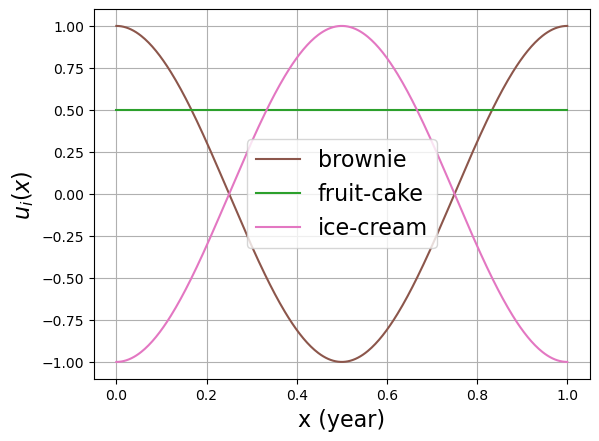

In [3]:
np.random.seed(42)
bounds=[[0,1]]
def fun(x,noise=0):
    u1 = np.cos(2*np.pi*x)
    u2 = 0.5+x*0 #np.cos(4*np.pi*(x-90/365))
    u3 = np.cos(2*np.pi*(x-1/2))
    return np.vstack([u1,u2,u3])+noise
Xpred=np.linspace(bounds[0][0],bounds[0][1],365)[:,None]

output = fun(Xpred[:,0])
plt.plot(Xpred[:,0],output[0,:],color='C5',label="brownie")
plt.plot(Xpred[:,0],output[1,:],color='C2',label="fruit-cake")
plt.plot(Xpred[:,0],output[2,:],color='C6',label="ice-cream")
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_i(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("figures/ThreeDessert.pdf")

## Thurstone's model

One natural way to represent label preferences is to define a utility function $u_i : \mathcal{X} \rightarrow \mathbb{R}$ for each label $c_i$, $i = 1,\dots,d$. Here, $u_i({ x})$ is the utility assigned to label $c_i$ by the object ${ x}$. To obtain a label preference for ${ x}$, the labels are ordered according to these utility functions, that is
$$
c_i \succ_{{ x}} c_j ~\text{ iff }~ u_i({ x})>u_j({ x}),
$$
For each label, it is assumed that the observed utility is perturbed by Gaussian noise:
\begin{equation}
    \label{eq:noise_thur}
    \widetilde{u}_i({ x}) = u_i({ x}) + v_i({ x}),
\end{equation}
where $v_i({ x}) \sim N(0,\sigma^2)$ is the noise associated to the label $i$ in the instance $k$, and preferences are determined as follows $
c_i \succ_{{ x}} c_j$ if $\widetilde{u}_i({ x})>\widetilde{u}_j({ x})$.

We simulate preferences according to this model and the three utility functions above.

In [4]:
n=50 #number of objects
np.random.seed(2)
X=np.sort(bounds[0][0]+(bounds[0][1]-bounds[0][0])*np.random.rand(n))[:,None]#(np.linspace(bounds[0][0],bounds[0][1],n)[:,None])
sigma=0.0
#number of labels
latent_dim = 3

noise = sigma*np.random.randn(latent_dim,n)

#generate preference pairs for augmented model
pairs=[]
for ii in range(n):
    output = fun(X[ii,:],noise[:,[ii]])
    ind = np.argsort(-output[:,0])
    #print(ind)
    pairs.append([ii+n*ind[0],ii+n*ind[1]])
    pairs.append([ii+n*ind[1],ii+n*ind[2]])
pairs = np.vstack(pairs)
Xaugm = np.tile(X,(latent_dim,1))

In [5]:
Xaugm.shape

(150, 1)

We now use `gaussianNoisePreference` to learn the preferences using Thurstone's model.

In [6]:
# data dictionary
data = {}
data["Pairs"] = pairs
data["X"] = Xaugm

# define kernel and hyperparams
Kernel = BlockRBF# we use a diagonal block RBF kernel

# kernel parameter dictionary

params={'noise_variance': {'value':np.array([0.1]), 
                            'range':np.vstack([[0.001, 10.0]]),
                            'transform': paramz.logexp()}#
              }

for i in range(latent_dim):
    params['lengthscale_'+str(i)]={'value':0.3*np.ones(data["X"].shape[1],float), 
                                'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                                'transform': paramz.logexp()}
    params['variance_'+str(i)]={'value':np.array([30]), 
                                'range':np.vstack([[0.1, 200.0]]),
                                'transform': paramz.logexp()}



# define preference model 
model = gaussianNoisePreference(data,Kernel,params)
# compute hyperparameters
model.optimize_hyperparams(num_restarts=1)
print(model.params)
# sample from posterior
model.sample(nsamples=50000, tune=10000)

  0%|          | 0/200 [00:00<?, ?it/s]

Iteration 0  -17.264645198682896


/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/Python_preferences_GP/GPpref/notebooks/../model/gaussianNoisePreferenceFull.py:130: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  res = linprog(np.zeros(A.shape[1]),A_ub=-A,b_ub=-b, bounds=[[0.,1]]*A.shape[1],method='interior-point' )


{'noise_variance': {'value': array([0.00754251]), 'range': array([[1.e-03, 1.e+01]]), 'transform': <utility.paramz.logexp object at 0x7f23c5259a90>}, 'lengthscale_0': {'value': array([0.12911055]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7f23c50ae790>}, 'variance_0': {'value': array([10.08694198]), 'range': array([[1.e-01, 2.e+02]]), 'transform': <utility.paramz.logexp object at 0x7f23c50ae210>}, 'lengthscale_1': {'value': array([0.85231825]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7f23c5135290>}, 'variance_1': {'value': array([2.22663853]), 'range': array([[1.e-01, 2.e+02]]), 'transform': <utility.paramz.logexp object at 0x7f23c5135910>}, 'lengthscale_2': {'value': array([0.27546319]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7f23c5135550>}, 'variance_2': {'value': array([12.87687881]), 'range': array([[1.e-01, 2.e+02]]), 'transform': <utility.paramz.logexp object at 0x7f2

100%|████████████████████████████████████| 60000/60000 [03:17<00:00, 304.48it/s]


In [7]:
# predicted samples
predictions = model.predict(np.tile(Xpred,(latent_dim,1)))
# compute the lower and upper credible intervals
credib_int = az.hdi(predictions.T,0.95)

/tmp/ipykernel_2162368/635854206.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  credib_int = az.hdi(predictions.T,0.95)


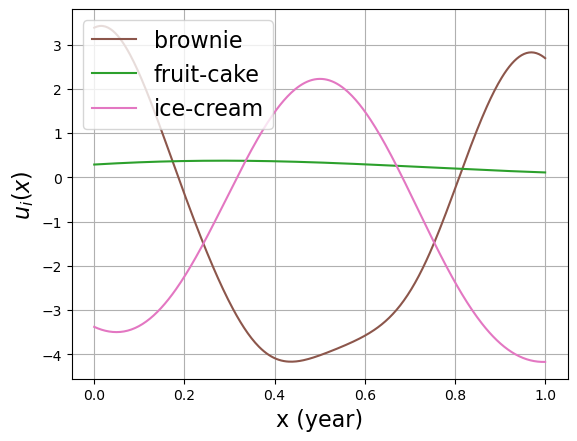

In [8]:
output = np.mean(predictions,axis=1)
u1 = output[0:Xpred.shape[0]]
u2 = output[Xpred.shape[0]:Xpred.shape[0]*2]
u3 = output[Xpred.shape[0]*2:]
plt.plot(Xpred[:,0],u1,color='C5',label="brownie")
plt.plot(Xpred[:,0],u2, color='C2',label="fruit-cake")
plt.plot(Xpred[:,0],u3, color='C6',label="ice-cream")
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_i(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstnoise.pdf")

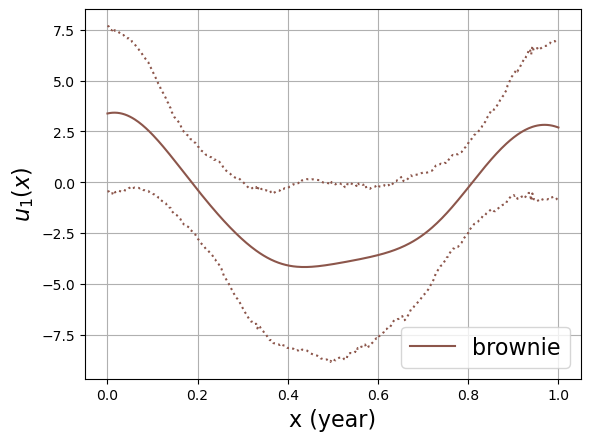

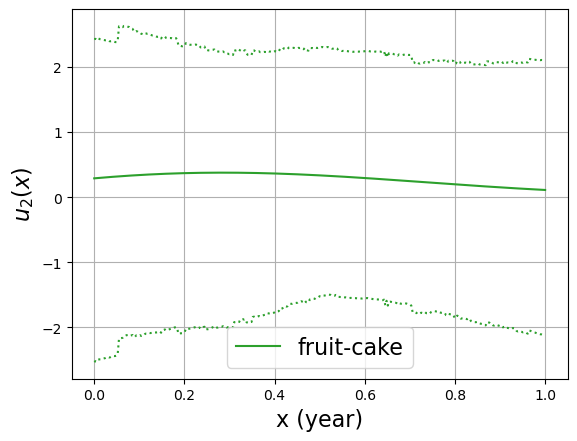

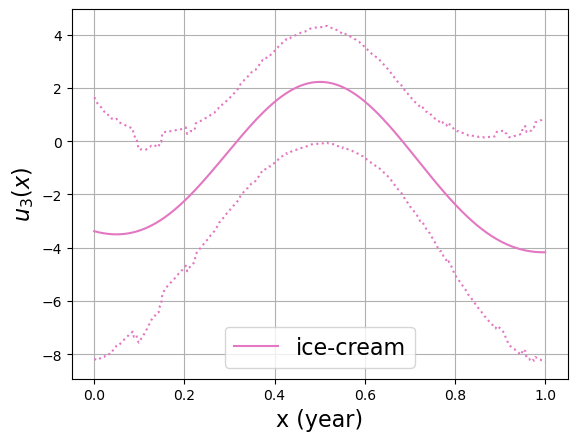

In [9]:
plt.plot(Xpred[:,0],u1,color='C5',label="brownie")
plt.plot(Xpred[:,0],credib_int[0:Xpred.shape[0],1],color='C5', linestyle=':')
plt.plot(Xpred[:,0],credib_int[0:Xpred.shape[0],0],color='C5', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_1(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu1.pdf")
plt.figure()
plt.plot(Xpred[:,0],u2, color='C2',label="fruit-cake")
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]:Xpred.shape[0]*2,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]:Xpred.shape[0]*2,0],color='C2', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_2(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu2.pdf")
plt.figure()
plt.plot(Xpred[:,0],u3, color='C6',label="ice-cream")
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]*2:,1],color='C6', linestyle=':')
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]*2:,0],color='C6', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_3(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu3.pdf")

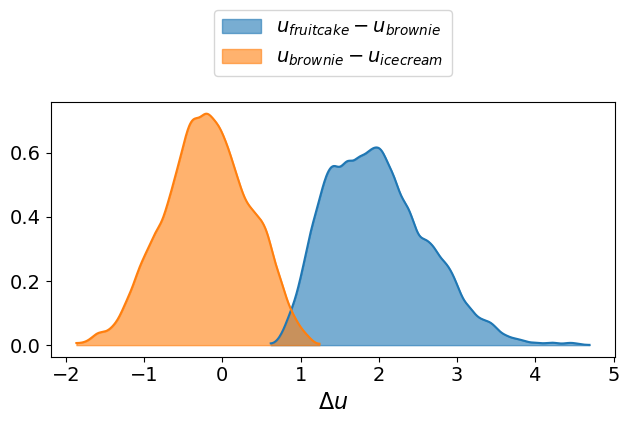

In [11]:
# predicted samples
Xpred1 = np.array([90/365])
predictions = model.predict(np.tile(Xpred1,(latent_dim,1)),)
import arviz as az
az.plot_dist(predictions[1,:]-predictions[0,:],color='C0',label="$u_{fruitcake}-u_{brownie}$",  fill_kwargs={'alpha': 0.6} )
az.plot_dist(predictions[0,:]-predictions[2,:],color='C1',label="$u_{brownie}-u_{icecream}$",  fill_kwargs={'alpha': 0.6} )
plt.legend(fontsize=14,loc='upper center', bbox_to_anchor=(0.5, 1.4))
plt.xlabel("$\Delta u$",fontsize=16)
plt.tight_layout()
plt.savefig("figures/ThreeDessertEstuDiff.pdf")

## Plackett-Luce model

Assume that, for each instance ${ x}^{(k)}$, we interpret a ranking of  the $d$ labels as a sequence of $d-1$ independent choices, that is first Alice chooses the first item, then chooses the second among the remaining alternatives, and so on. The Plackett-Luce (PL)  model is a distribution over rankings. 

Consider a training dataset including the ranking of $d$-labels for each one of the $m$ covariates:
$$
\mathcal{D}_m=\{c_{\pi^{(k)}_1} \succ_{{ x}^{(k)}} c_{\pi^{(k)}_2} \succ_{{ x}^{(k)}} c_{\pi^{(k)}_3} \succ_{{ x}^{(k)}} \dots  \succ_{{ x}^{(k)}} c_{\pi^{(k)}_d}: ~~\boldsymbol{\pi}^{(k)} \in \Pi_d, x^{(k)} \in X,~ k=1,\dots,m\}.
$$
Under the assumption that the $m$ ranking statements are conditionally independent given
 $\mathbf{u}(X)$, we obtain the likelihood:
$$
    p(\mathcal{D}_m|{ u}(X))=\prod_{k=1}^m \prod_{i=1}^{d-1} \frac{e^{u_{\pi_i^{(k)}}({ x}^{(k)})}}{\sum_{j=i}^d e^{u_{\pi_j^{(k)}}({ x}^{(k)})}}.
$$

We use the same data generated above to learn the posterior. In this case, we will use Variational Inference to approximate the posterior.

In [12]:
from kernel import jaxrbf
Ranking=[]
for i in range(n):
    val=fun(X[i,:])
    Ranking.append(np.argsort(-val[:,0]))

latent_dim = len(np.unique(Ranking))

data={'X': X,
      'Ranking': Ranking,
          }
params={}
for i in range(latent_dim):
    params['lengthscale_'+str(i)]={'value':0.3*np.ones(data["X"].shape[1],float), 
                                'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                                'transform': paramz.logexp()}
    params['variance_'+str(i)]={'value':np.array([3]), 
                                'range':np.vstack([[0.1, 500.0]]),
                                'transform': paramz.logexp()}





# define kernel and hyperparams
Kernel = jaxrbf.RBF

# define preference model 
model = PlackettLuceGP(data,Kernel,params,latent_dim)
# compute hyperparameters
model.optimize_hyperparams(niterations=1000)
#print(model.params)
# predicted samples
predictions = model.predict_VI(Xpred)


262.91295833497327
80250.74312704908
34.46681745895184
34.46681749362105
34.46681745882371


 lower bound 89798.02031347895: 100%|█████████████| 1/1 [00:03<00:00,  3.32s/it]


/tmp/ipykernel_2162368/4256147454.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  credib_int = az.hdi(samples.T,0.95)


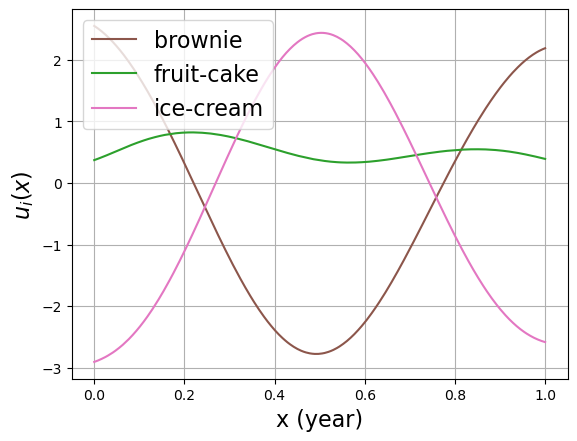

In [13]:
mean = predictions[0]
Sigma = predictions[1]
from scipy.stats import multivariate_normal
samples = multivariate_normal(mean[:,0],Sigma+1e-3*np.eye(Sigma.shape[0])).rvs(40000).T
credib_int = az.hdi(samples.T,0.95)
output = np.mean(samples,axis=1)
u1 = output[0:Xpred.shape[0]]
u2 = output[Xpred.shape[0]:Xpred.shape[0]*2]
u3 = output[Xpred.shape[0]*2:]
plt.plot(Xpred[:,0],u1,color='C5',label="brownie")
plt.plot(Xpred[:,0],u2, color='C2',label="fruit-cake")
plt.plot(Xpred[:,0],u3, color='C6',label="ice-cream")
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_i(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstPL.pdf")

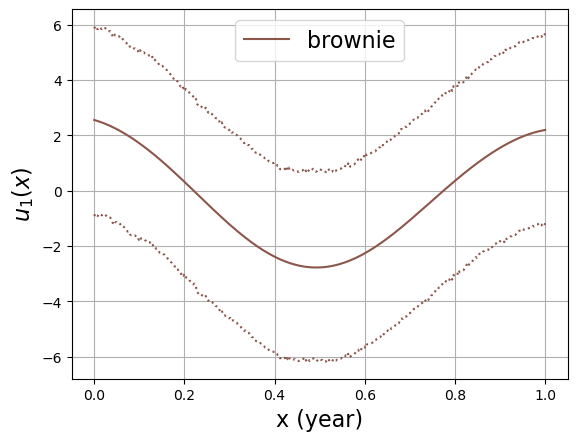

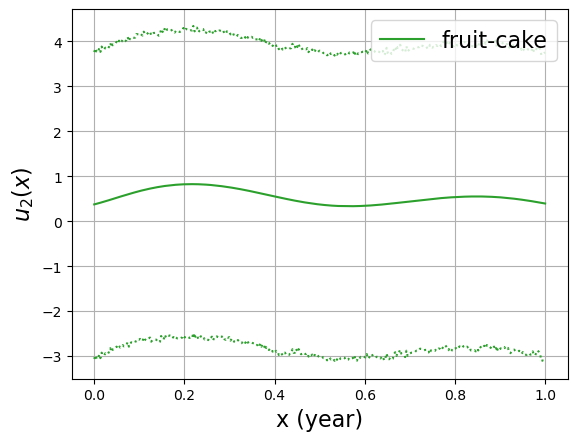

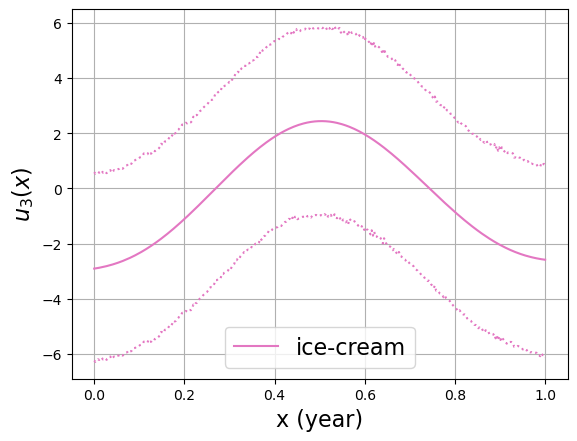

In [14]:
plt.plot(Xpred[:,0],u1,color='C5',label="brownie")
plt.plot(Xpred[:,0],credib_int[0:Xpred.shape[0],1],color='C5', linestyle=':')
plt.plot(Xpred[:,0],credib_int[0:Xpred.shape[0],0],color='C5', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_1(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu1PL.pdf")
plt.figure()
plt.plot(Xpred[:,0],u2, color='C2',label="fruit-cake")
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]:Xpred.shape[0]*2,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]:Xpred.shape[0]*2,0],color='C2', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_2(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu2PL.pdf")
plt.figure()
plt.plot(Xpred[:,0],u3, color='C6',label="ice-cream")
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]*2:,1],color='C6', linestyle=':')
plt.plot(Xpred[:,0],credib_int[Xpred.shape[0]*2:,0],color='C6', linestyle=':')
plt.xlabel("x (year)",fontsize=16)
plt.ylabel("$u_3(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("ThreeDessertEstu3PL.pdf")
        

To predict a distribution over the orderings, we can sample from the posterior. For this  example, the ranking distribution at day $x=0.25$ is computed hereafter.

In [38]:
ind= np.argmin(abs(Xpred-0.25))
u1 = samples[ind]
u2 = samples[ind+Xpred.shape[0]]
u3 = samples[ind+2*Xpred.shape[0]]
labels=np.array(["b","f","i"])
dict={}
for i in range(len(u1)):
    ind=np.argsort([-u1[i],-u2[i],-u3[i]])
    key=''.join(list(labels[ind]))
    if key in dict.keys():
        dict[key]=dict[key]+1/samples.shape[1]
    else:
        dict[key]=1/samples.shape[1]

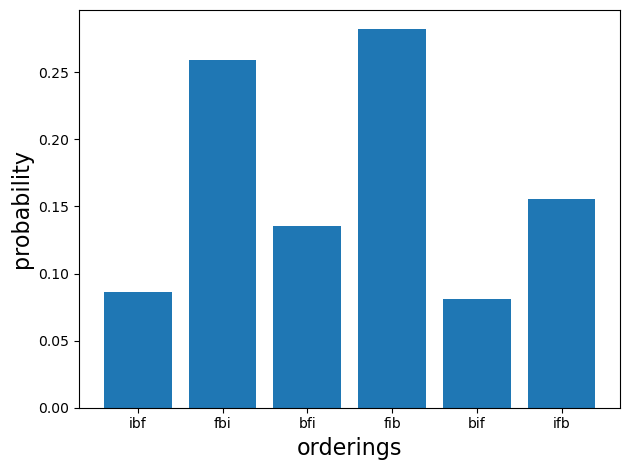

In [44]:
plt.bar(range(len(dict)), list(dict.values()), align='center')
plt.xticks(range(len(dict)), list(dict.keys()))
plt.xlabel("orderings",fontsize=16)
plt.ylabel("probability",fontsize=16)
plt.tight_layout()
plt.savefig("figures/orderings.pdf")

(1095, 40000)